In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
import warnings
warnings.filterwarnings('ignore')

# link
# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [2]:
df = pd.read_csv('../cleaned_cpo_price.csv', index_col="Date").dropna()
df

,Price
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
21/12/2022,3901.5
22/12/2022,3886.5
23/12/2022,3890.5


Text(0.5, 0, 'Date')

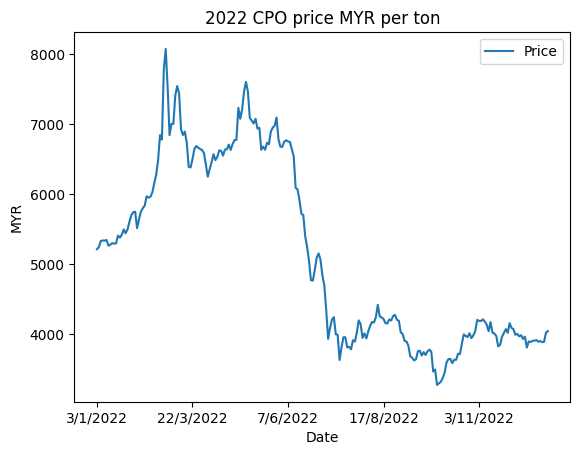

In [3]:
df.plot()
plt.title("2022 CPO price MYR per ton")
plt.ylabel("MYR")
plt.xlabel("Date")

In [4]:
df

,Price
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
21/12/2022,3901.5
22/12/2022,3886.5
23/12/2022,3890.5


# Initial EDA

In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
def adf_test(df):
    """Augmanted Dickey-Fuller test"""
    result = adfuller(df.Price.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(df)


ADF Statistic: -0.933500
p-value: 0.776740


Text(0.5, 1.0, 'Autocorrelation Original Series')

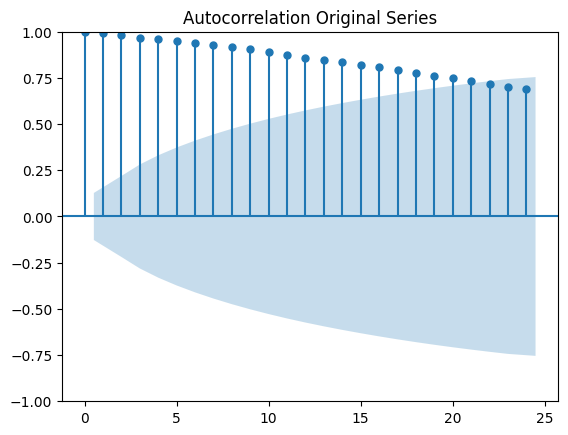

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.Price)
plt.title("Autocorrelation Original Series")

Text(0.5, 1.0, 'Partial Auto Original Series')

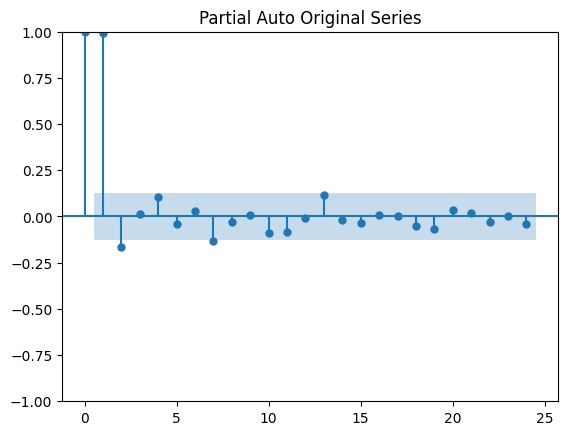

In [7]:
plot_pacf(df.Price)
plt.title("Partial Auto Original Series")

# Modelling

In [8]:
# split
size = round(len(df)*.8)
train = df.iloc[-size:,:]
test = df.iloc[:-size,:]
len(train)
len(test)

47

In [9]:
from statsmodels.tsa.arima.model import ARIMA


# 1,1,2 ARIMA Model
model = ARIMA(train.Price, order=(0,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  190
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1426.684
Date:                Wed, 12 Jul 2023   AIC                           2861.368
Time:                        21:54:30   BIC                           2874.356
Sample:                             0   HQIC                          2866.629
                                - 190                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4896.5005    123.490     39.651      0.000    4654.464    5138.537
ma.L1          1.3526      0.106     12.801      0.000       1.146       1.560
ma.L2          0.9998      0.151      6.635      0.0

In [10]:
pred_t = model_fit.predict(start = 0, end = 237)
pred_t

0      4896.500515
1      6196.645951
2      5580.595043
3      5895.486681
4      6100.873814
          ...     
233    4896.500515
234    4896.500515
235    4896.500515
236    4896.500515
237    4896.500515
Name: predicted_mean, Length: 238, dtype: float64

In [11]:
pred = model_fit.predict(start=237+1, end=237+12)
pred

238    4896.500515
239    4896.500515
240    4896.500515
241    4896.500515
242    4896.500515
243    4896.500515
244    4896.500515
245    4896.500515
246    4896.500515
247    4896.500515
248    4896.500515
249    4896.500515
Name: predicted_mean, dtype: float64

<Axes: >

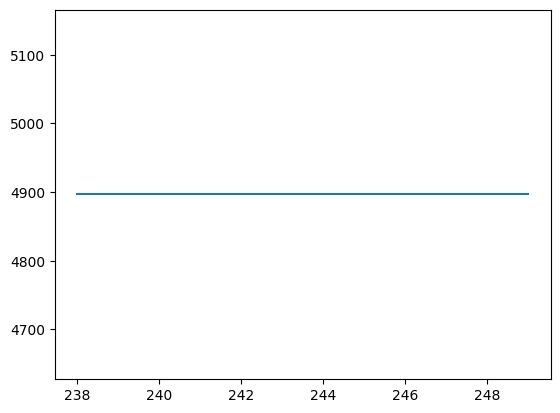

In [12]:
pred.plot()

# one step ahead forecast

In [13]:
#RMSE
from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    test_ = df_cp.iloc[size_:,:]

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(0,0,2))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    err = np.sqrt(mean_squared_error(test_, pred)) #rmse
    return err
    
one_step_ahead(df, .8)

def loop_pct():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct()


,pct,res
0,0.80,1417.528780
1,0.85,1338.618675
2,0.90,1281.455861
3,0.95,1237.350641


In [14]:
#MAPE
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
def one_step_ahead_mape(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    test_ = df_cp.iloc[size_:,:]

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(0,0,2))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    err = mean_absolute_percentage_error(test_, pred) #mape
    return err
    
one_step_ahead_mape(df, .8)
def loop_pct_mape():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead_mape(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_mape()

,pct,res
0,0.80,0.354943
1,0.85,0.334581
2,0.90,0.321816
3,0.95,0.313255


In [15]:
# pct change measurement

from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead_chg(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    test_ = df_cp.iloc[size_:,:]
    pct_change_test_ = 100 * test_.pct_change().dropna()

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(0,0,2))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    pred_pct_change = 100 * pred.pct_change().dropna()
    err = np.sqrt(mean_squared_error(pct_change_test_, pred_pct_change)) #rmse
    return err
    
one_step_ahead_chg(df, .8)

def loop_pct_chg():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead_chg(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_chg()

,pct,res
0,0.80,1.822284
1,0.85,1.996575
2,0.90,2.369323
3,0.95,4.017404


### Forecast include train test error

In [16]:
# RMSE within-sample & out-sample
from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead_train(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    test_ = df_cp.iloc[size_:,:]

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(0,0,2))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    pred_t = model_fit.predict(start= 0, end = len(train_)-1)
    err_t = np.sqrt(mean_squared_error(train_, pred_t))
    err = np.sqrt(mean_squared_error(test_, pred)) #rmse
    # return pd.concat([err_t,err], axis= 1)
    return err_t, err
    
one_step_ahead_train(df, .8)

def loop_pct_train():
    dict = {'pct':[], '(train, test)':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['(train, test)'].append(one_step_ahead_train(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_train()

,pct,"(train, test)"
0,0.80,"(470.81097394562835, 1417.5287797436033)"
1,0.85,"(488.06861175694456, 1338.6186754254456)"
2,0.90,"(484.3612716791848, 1281.455860656972)"
3,0.95,"(598.5670037624008, 1237.3506413325665)"


### Plotting the end result

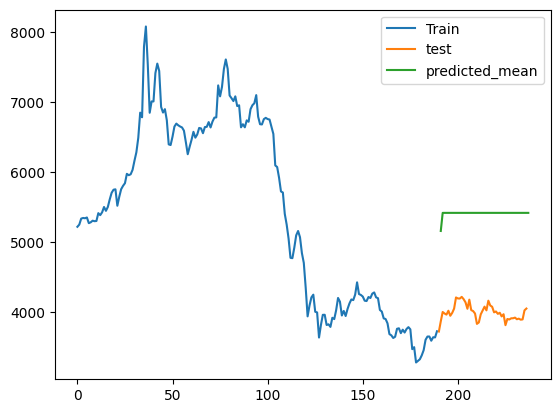

In [17]:
# ploting results
def plot_res(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    train_.rename(columns={'Price': 'Train'}, inplace=True)
    test_ = df_cp.iloc[size_:,:]
    test_.rename(columns={'Price': 'test'}, inplace=True)
    # pct_change_test_ = 100 * test_.pct_change().dropna()

    # MA 2
    model = ARIMA(train_.Train, order=(0,0,2))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))

    df_plot = pd.concat([train_, test_], axis= 1)
    df_plot.reset_index(inplace=True, drop=True)
    df_plot = pd.concat([df_plot, pred], axis= 1)
    # df_plot.rename(columns={'Price': 'Train', 'Price': 'Test', 'predicted_mean': 'Forecast'}, inplace=True)
    df_plot.plot()



    
plot_res(df, .8)


<Axes: >

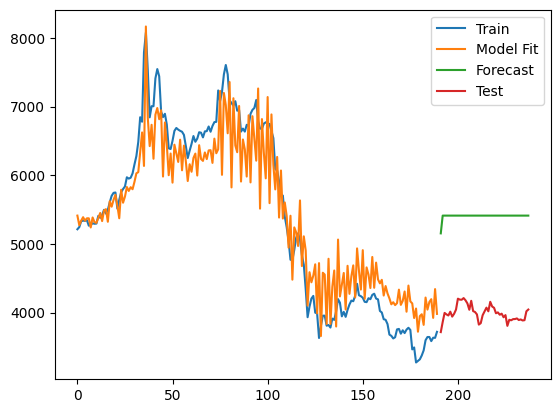

In [18]:
def plot_res_train(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    train_.rename(columns={'Price': 'Train'}, inplace=True)
    test_ = df_cp.iloc[size_:,:]
    test_.rename(columns={'Price': 'test'}, inplace=True)
    # pct_change_test_ = 100 * test_.pct_change().dropna()

    # MA 2
    model = ARIMA(train_.Train, order=(0,0,2))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    pred_t = model_fit.predict(start= 0, end = len(train_)-1)

    df_plot = pd.concat([train_, pred_t], axis= 1)
    df_plot.reset_index(inplace=True, drop=True)
    df_plot = pd.concat([df_plot, pred], axis= 1)
    test_.set_index(keys = pred.index, inplace = True)
    df_plot = pd.concat([df_plot, test_], axis= 1)
    df_plot.columns = ['Train', 'Model Fit', 'Forecast', 'Test']
    

    return df_plot.plot()

plot_res_train(df, .8)